# The Isoperimetric Problem

For a solution to the isoperimetric problem using a Python script instead of a notebook, see the [isoperimetric Python script documentation](../scripts/isoperimetric.rst).

## Problem Description

The isoperimetric problem, or Dido's problem <cite data-footcite="Bandle:2017">(Bandle, 2017)</cite>, is to find the curve of fixed length that encloses the maximum area. For a differentiable, closed curve in the $x$, $y$ plane, the area to be maximized is:
$$
    J = \frac{1}{2} \oint y \: dx - x \: dy
      = \frac{1}{2} \int_{0}^{L} \bigl\{y(s) \,x^\prime(s) - x(s) \,y^\prime(s)\bigr\} \: ds  \tag{1}
$$
where here $x$ and $y$ are parameterized by the arc length $s$ along the curve, and $L$ is the total length of the curve.

If we take the dynamics to be
$$
    x^\prime(s) = u_{0}(s), \quad y^\prime(s) = u_{1}(s) \tag{2}
$$
then we can rewrite the cost as
$$
    J = \frac{1}{2} \int_{0}^{L} \bigl\{y(s)\,u_0(s) - x(s)\,u_1(s)\bigr\} \: ds  \tag{3}
$$
The length of the curve is
$$
    L = \int_{0}^{L} \sqrt{dx^{2} + dy^{2}}
      =\int_{0}^{L} \sqrt{x^\prime(s)^{2}+x^\prime(s)^{2}} \: ds
      =\int_{0}^{L} \sqrt{u_1(s)^{2}+u_2(s)^{2}} \: ds  \tag{4}
$$
To ensure that the integral is indeed $L$, we must impose the path constraint
$$
    \|\mathbf{u}\|^2 = u_1(t)^{2}+u_2(t)^{2} = 1 \tag{5}
$$
So the problem to be solved is to maximize the cost $J$ given by (3) subject to the dynamics (2) and the path constraint (3). To ensure that the curve is closed, we impose the endpoint constraints
$$
    x(L) = x(0), \quad y(L) = y(0)  \tag{6}
$$
Finally, we want the centroid of the curve to be at the origin. (If we don't apply some constraint on the position, the solution can lie anywhere in the plane.) So we also apply the integral constraints
$$
    \int_0^L x(s)\:ds = 0, \quad \int_0^L y(s)\:ds = 0 \tag{7}
$$
For the solution presented below, we take the arc length to be $L=1$.

## YAPSS Solution

Begin by importing needed packages and instantiating the problem:

In [1]:
# third party imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

# package imports
from yapss import Problem

# problem has 1 phase, with 2 states, 2 controls, 1 path constraint, and 3 integrals.
# There are 2 constraints to constrain the curved to be closed
problem = Problem(name="Isoperimetric Problem", nx=[2], nu=[2], nq=[3], nh=[1], nd=2)

Next define the callback functions. Note that this problem is defined as a maximization rather than a minimization. Rather than change the sign of the objective, we set ``problem.scale.objective=1``.

In [2]:
# callback functions


def objective(arg):
    # Maximize the integral that defines the enclosed area
    arg.objective = arg.phase[0].integral[0]


def continuous(arg):
    # Extract the state and control
    x, y = arg.phase[0].state
    ux, uy = arg.phase[0].control

    # The dynamics are trivial
    arg.phase[0].dynamics[:] = ux, uy

    # The integrals are the eclosed area, and the x and y centroids of the boundary
    arg.phase[0].integrand[0] = (y * ux - x * uy) / 2
    arg.phase[0].integrand[1] = x
    arg.phase[0].integrand[2] = y

    # Path constraint
    arg.phase[0].path[0] = ux**2 + uy**2


def discrete(arg):
    # The two ends of the boundary are the same
    arg.discrete[:2] = arg.phase[0].final_state - arg.phase[0].initial_state


problem.functions.objective = objective
problem.functions.continuous = continuous
problem.functions.discrete = discrete

# set objective scale to -1 to maximize area
problem.scale.objective = -1

Set the bounds on the variables and constraints:

In [3]:
# problem bounds
bounds = problem.bounds.phase[0]

# Length of the boundary is 1
bounds.path.lower[0] = 1
bounds.path.upper[0] = 1
bounds.initial_time.lower = bounds.initial_time.upper = 0.0
bounds.final_time.lower = bounds.final_time.upper = 1.0

# All the discrete constraint functions should be 0
problem.bounds.discrete.lower = problem.bounds.discrete.upper = [0, 0]

# Bounds on centroid
bounds.integral.lower[1:] = 0
bounds.integral.upper[1:] = 0

The initial guess is a square with perimeter equal to 1:

In [4]:
# initial guess
guess = problem.guess.phase[0]
guess.time = [0.0, 0.25, 0.5, 0.75, 1.0]
guess.state = np.array([[1.0, 1.0, -1.0, -1.0, 1.0], [1.0, -1.0, -1.0, 1.0, 1.0]]) / 8

To get a highly accurate result, use a mesh for the the segments that have a (somewhat) large number of collocation points (12). Three such segments are more than sufficient.

In [5]:
# mesh
m, n = 3, 12
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].fraction = m * (1.0 / m,)

Solver options:

In [6]:
# yapss options
# Best results are usually obtained with automatic differentiation and second derivatives
problem.derivatives.method = "auto"
problem.derivatives.order = "second"
problem.spectral_method = "lgl"

# ipopt options
# Set fairly tight tolerances
problem.ipopt_options.tol = 1e-14
problem.ipopt_options.acceptable_iter = 0

# Ipopt options to limit printed output
problem.ipopt_options.print_level = 3
problem.ipopt_options.print_user_options = "no"
problem.ipopt_options.sb = "yes"

Now solve the problem:

In [7]:
# solve the problem
solution = problem.solve()

Total number of variables............................:      143
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      111
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:  -7.9577471545947659e-02    7.9577471545947659e-02
Dual infeasibility......:   6.7291007835312833e-16    6.7291007835312833e-16
Constraint violation....:   1.9428902930940239e-15    1.9428902930940239e-15
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

## Plot of Solution

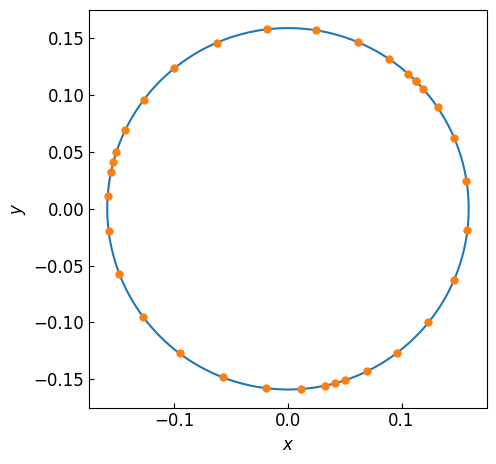

In [8]:
# plot the solution
x, y = solution.phase[0].state
s = solution.phase[0].time
sp = np.linspace(0, 1, 500)
xp = interp1d(s, x, kind="cubic")(sp)
yp = interp1d(s, y, kind="cubic")(sp)

plt.figure()
plt.plot(xp, yp)
plt.plot(x, y, ".", markersize=10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.axis("square")
plt.tight_layout()

Not surprisingly, the optimal curve is a circle centered at the origin. For a circle with circumference $L$, the radius is $r={L}/{2\pi}$, and the area is
$$
    A = \pi r^2 = \frac{L^2}{4\pi}
$$
So for our optimal control problem, the optimal value for the area should be
$$
    J = \frac{1}{4\pi}
$$
We can check that result easily enough:

In [9]:
# check the result
area = solution.objective
area_ideal = 1 / (4 * np.pi)
rel_error = abs(area - area_ideal) / area_ideal
print(f"Maximum area   = {area}")
print(f"1 / (4 pi)     = {area_ideal}")
print(f"Relative error = {rel_error}")

Maximum area   = 0.07957747154594766
1 / (4 pi)     = 0.07957747154594767
Relative error = 1.743934249004316e-16


The relative error is very small — a small multiple of machine precision. (The error might even be zero on some machines!)

## References